# Exotic Models Notebook
#### David W. Barker

### Purpose
Intended for all the code and figures needed for my first paper on exotic physic models and how they may effect the 21 cm signal and what kind of signal extraction will be required to robustly extract said signal...wow that is wordy, but it's okay for now.

In [1]:
pip install -U sphinx

DEPRECATION: Loading egg at /home/dbarker7752/anaconda3/lib/python3.12/site-packages/ULSA-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 7.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.2/633.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: sphinxcontrib-qthelp
    Found existing installation: sphinxcontrib-qthelp 1.0.3
    Uninstalling sphinxcontrib-qthelp-1.0.3:
      Successfully uninstalled sphinxcontrib-qthelp-1.0.3
  Attempting uninstall: sphinxcontrib-htmlhelp
    Found existing installation: sphinxcontrib-htmlhelp 2.0.0
    Uninstalling sphinxcontrib-htmlhelp-2.0.0:
      Success

In [1]:
### Boilerplate ###
## Boiler Plate that is required to run to make any cell below this work ##
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/dbarker7752/py21cmsig")
import py21cmsig
from pylinex import BasisSum, MetaFitter, AttributeQuantity, TrainedBasis, RepeatExpander, NullExpander
from tqdm import tqdm
import healpy as hp
from scipy import stats
from scipy.optimize import fsolve
from importlib import reload
import scipy
import perses
import copy
import os
import lmfit
from astropy.io import fits
from lmfit import Minimizer, Parameters, create_params, report_fit
import lochness
import perses.models

# universal variables
frequencies = np.arange(5,50,0.5)

# 10 LSTs for 32 bit map
f = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/master_foreground_array_32bit_10LSTs","r")
master_foreground_array = np.array(f["sky_maps"])

/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.192 s.


### Best Fit to the Foreground

So the best fit method will be hugely important for the second paper on degeneracy and optimizing training sets and such, but this one could benefit from it as well and I'd like to work on that right now because it's kinda fun.

Idea 1): Use the five region model and its 15 parameters and set that equal to a specific brightness temperature at a specific frequency. This is one equation. Now do that for 14 more frequency bins and slide through all frequency bins to get a distribution of solutions per frequency. I'm intersted to see what this looks like. It should just move in a noisy pattern related to the radiometer noise. Let's find out.
-   Conclusion: Pretty sure this can't work unless your data is exactly following a synchrotron equation and we have Dark Ages signal (however small) and also noise (not so terribly small) that will cause the given temperatures to not be perfect and therefore be unsolvable in an analytical way. It has to be numerical! Let's call this idea and move on to the next.

Idea 2): Just make a really big training set that stabilizes the chi-squared (hopefully around 1.0) and trim that training set to see if it adjusts your ability to extract the model. It really might be that simple. Let's see.

Idea 3): Do you telescoping method where you build a training set and then choose the best 10% or so, but instead of taking the full parameter range of all the curves, form a covariance matrix to further constrain the parameters. Not quite sure exactly how to implement this right now but we'll figure it out if the first idea doesn't work



In [ ]:
### Idea 1 ###
## plan is to use scipy to solve an algebraic equation for our five region model.

def n_region_synchrotron_foreground(parameters,frequencies,reference_frequency=408):
    """Creates a set of equations with frequency as an input that can be plugged into scipy.optimize.fsolve to get the parameter values.
    
    Parameters
    ==============================
    parameters: List of parameters to apply to the model. The shape must be (number of regions, 3). The correct order for synchrotron is [Amplitude, spectral index, spectral curvature]
    frequencies: The array of frequencies to evaluate the model at.
    reference_frequency: The frequency that non dimensionalizes the frequency array for the synchrotron equation (in MHz). Usually its 408 MHz for anything related to Dark Ages or Cosmic Dawn.
                         (has to do with the EDGES experiment and the trough they detected, so it certainly is a bit arbitrary.)
    
    Returns
    ==============================
    temperature_array: array of temperatures associated with the input frequencies"""
    temperature_array = np.zeros(len(frequencies))
    for i,f in enumerate(frequencies):
        element = 0
        for n in range(len(parameters)):          # loops through all the regions, which is defined by the user simply based on the shape of the parameter array (see the documentation above).
            element += parameters[n][0]*(f/reference_frequency)**(parameters[n][1]+parameters[n][2]*np.log(f/reference_frequency))
        temperature_array[i] = element

    return temperature_array
            

In [ ]:
sol = fsolve(n_region_synchrotron_foreground,[[10,-2.5,-0.015],[10,-2.5,-0.015],[10,-2.5,-0.015],[10,-2.5,-0.015],[10,-2.5,-0.015]])

Region 1: 2458
Region 2: 2457
Region 3: 2458
Region 4: 2457
Region 5: 2458


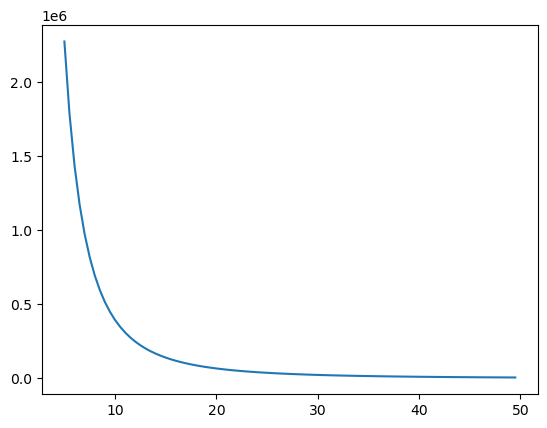

In [ ]:
# let's test out the function:

parameters = np.array([[1.59202418e+01,-2.65279830e+00,-1.37293590e-02],[1.66130589e+01,-2.69062579e+00,-1.47582387e-02],[1.89769800e+01,-2.68235795e+00,-1.34495335e-02],\
                       [2.42115565e+01,-2.66682587e+00,-1.20169084e-02],[5.22431891e+01,-2.65055339e+00,-2.42275191e-02]])      # five region parameter example (best fit to base ULSA)

temperature_array_test=n_region_synchrotron_foreground(parameters,frequencies)      # testing out the above function using the ULSA best fit parameters

sky_map = master_foreground_array[0]  # sets the sky map as the ULSA 32 bit map with the dead zone removed and CMB removed
reference_frequency = 25    # Reference frequency to determine the regions at [MHz]
n_regions = 5
patch=perses.models.PatchyForegroundModel(frequencies,sky_map[reference_frequency-1],n_regions)
region_indices=patch.foreground_pixel_indices_by_region_dictionary
print(f"Region 1: {len(region_indices[0])}")
print(f"Region 2: {len(region_indices[1])}")
print(f"Region 3: {len(region_indices[2])}")
print(f"Region 4: {len(region_indices[3])}")
print(f"Region 5: {len(region_indices[4])}")

### The size of each region in pixels is close enough to equal ###

plt.plot(frequencies,temperature_array_test/5) # divided by 5 because the convention of the patchy sky model ensures that the regions are equally sized over the full sky.